# Preparation for covariate modeling:

In this notebook we prepare the input files for modeling effects of demographic covariates (age, sex, smoking history, etc.) plus anatomical region of the sample on gene expression. The actual modeling is done in R (see "R" directory in this HLCA github repository).

### Import modules, set paths, load files etc.:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import os

# import custom scripts
sys.path.append("../../scripts/")
import utils
import LCA_GLMM_data_filtering

# stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

for pretty code formatting (not needed to run code):

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v1.h5ad"
dir_output = "../../results/covariate_modeling/input/"  # here we'll store the input for the actual modeling (which will happen in R)

load files:

In [4]:
adata = sc.read(path_HLCA)

### Adapt covariate encoding for smoking and anatomical region:

encode smoking status into continuous scale, ranging from 0 to 1:

In [5]:
smoking_to_cont = {"active": 1, "former": 0.5, "never": 0}

In [6]:
adata.obs["smoking_status_num"] = adata.obs.smoking_status.map(smoking_to_cont).astype(
    float
)

As the nose often shows distinct expression from the gradients in expression we observe along the proximal-distal axis in the airways/lungs, we will model nose separately from anatomical region ccf score. We will therefore add a "nose" variable, set to 1 for all nose cells and 0 for all other cells. Since we're adding the nose variable, we'll set nose anatomical region ccf score to the next lowest ccf score (we don't want to model it twice), i.e. same as trachea (0.36)

In [7]:
adata.obs["nose"] = (adata.obs.anatomical_region_level_1 == "nose").astype(int)

In [8]:
adata.obs.loc[
    adata.obs.anatomical_region_level_1 == "nose", "anatomical_region_ccf_score"
] = 0.36

set "nan", np.nan, None and "None" all to nan:

In [9]:
none_entries = adata.obs.applymap(utils.check_if_nan)
adata.obs = adata.obs.mask(none_entries.values)

### parameter settings:

In [10]:
min_n_cells_per_gene = 50 # minimum number of cells expressing the gene in a cell type for a gene to be included in the modeling
min_n_cells_per_sample = 10  # as in bioconductor Marioni tutorial
min_n_subj_per_dataset = 2 # minimum number of subjects that pass filtering for a dataset to be included in the modeling. (Note that we treat dataset as a random effect, and therefore it would not make sense to include datasets with only a single subject.)
min_prop_ann = 0.5 # This parameter is not currently used, but represents the minimum fraction of samples annotated for a metadata category for it to be included in the modeling.
min_inst_per_group = 3 # number of "representative" samples for a group to be included in the modeling (e.g. if only 2 samples from men pass filtering, we cannot model sex, or if only 2 samples from a specific ethnicity pass filtering, we cannot model that ethnicity.)
max_vif = 5 # maximum variance inflation factor (at subject level) for a cell type to be modeled. Cell types with VIFs > max_vif in the subject design matrix will not be modeled.

### Inspect number of subjects for which data is available per celltype:

Check subject diversity per cell type. Collect statistics:

In [11]:
donor_ct_overview = (
    adata.obs.groupby(["manual_ann_grouped", "subject_ID"])
    .agg({"manual_ann_grouped": "count", "BMI": "nunique", "ethnicity": "nunique"})
    .rename(columns={"manual_ann_grouped": "n_cells"})
)
donor_ct_overview["BMI_and_ethnicity"] = [
    bmi == 1 and eth == 1
    for bmi, eth in zip(donor_ct_overview["BMI"], donor_ct_overview["ethnicity"])
]
# keep only those rows where the cell count is greater than min_n_cells
donor_ct_overview = donor_ct_overview.loc[
    donor_ct_overview.n_cells > min_n_cells_per_sample, :
]
# store subject_ID as column in df
donor_ct_overview["subject_ID"] = donor_ct_overview.index.get_level_values(level=1)

In [12]:
ct_overview = donor_ct_overview.groupby("manual_ann_grouped").agg(
    {
        "n_cells": "sum",
        "subject_ID": "nunique",
        "BMI": "sum",
        "ethnicity": "sum",
        "BMI_and_ethnicity": "sum",
    }
)

This overview shows the number of subjects that contain metadata for each of the listed covariates. Modeling BMI and ethnicity together will reduce the number of subjects that can be included (as we cannot include subjects that have an NA for one of the covariates). As ethnicity of the subjects in the HLCA core sadly is largely white, and we are under-powered to model effects of other (under-represented) ethnicities given the total amount of data, we will exclude ethnicity from the modeling for now. Future versions of the atlas will hopefully resolve this issue and provide better power for modeling ethnicity.

In [13]:
ct_overview.sort_values(by="BMI_and_ethnicity", ascending=False).head(10)

,n_cells,subject_ID,BMI,ethnicity,BMI_and_ethnicity
manual_ann_grouped,,,,,
Multiciliated,41040,89,65,82,64.0
DC2,9063,77,55,73,54.0
Secretory,76440,69,52,63,51.0
T cell lineage,50788,72,51,68,50.0
Monocytes,26441,72,48,68,47.0
EC venous,12905,67,46,63,45.0
Basal,84581,57,45,51,44.0
Monocyte-derived Mφ,28151,68,41,63,40.0
Alveolar macrophages,78734,63,40,58,39.0


### Generate data for modeling:

Here, we will filter the data, check whether covariates are sufficiently independent to model, scale variables, and then store filtering and colinearity information, plus the data needed for modeling.

The filtering will happen based on the parameters set above, and for each cell type we will repeat rounds of filtering until all filtering criteria are fulfilled for the largest possible set of samples.<br>
We will also check variance inflation factors (vifs) in the subject design matrix to check if covariates are not too highly correlated, with max_vif representing the maximum acceptable vif for a cell type to be modeled.<br>
For the modeling, we will extract the sum of the raw counts for every gene, for every sample, for every cell type (these are the pseudo-bulks that will be used for the modeling). Normalization will be done in the R modeling script. <br>
Finally, we will re-scale the continuous variables that aren't already scaled (i.e. age, BMI) so that the 10th percentile across all data is set to 0, and the 90th percentile is set to 1. This will enable easier comparison and interpretation of effect sizes after the modeling.

Subsetting to cells with manual annotation Alveolar macrophages...
setting subadata.X to raw counts
subadata shape: (78816, 28527)
subadata shape after gene filtering: (78816, 18068)
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 119
number of samples to remove because of low number of cells: 32
Number of samples after filtering: 87
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 10
Number of datasets to remove because of fewer than 2 subjects: 0
set()
Number of datasets after filtering: 10 

Number of samples before filtering: 87
Number of samples after filtering: 87
#3: take out under-annotated categories:
Number of cats fully annotated: 4
['age', 'anatomical_region_ccf_score', 'nose', 'sex']
Number of cats with at least fraction 0.5 annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex', 'smoking_status_num']
Number of cats not sufficiently annotated: 0
[]
#4: take out sample

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


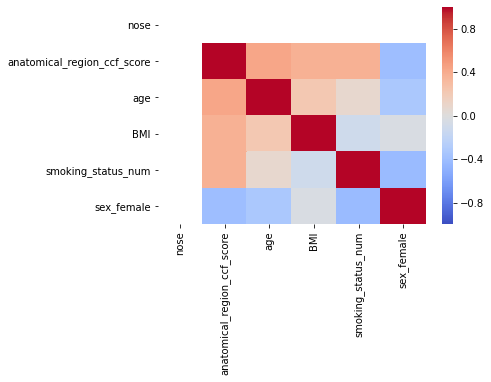

subject VIFs:
   VIF Factor            features
0    1.157820                 age
1    1.107078                 BMI
2    1.111105  smoking_status_num
3    1.184572          sex_female


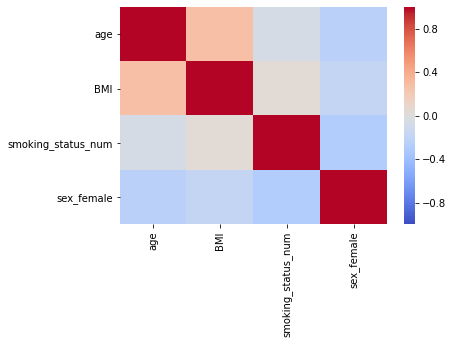

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Innate lymphoid cell NK...
setting subadata.X to raw counts
subadata shape: (16978, 28527)
subadata shape after gene filtering: (16978, 12364)
creating directory: ../../results/covariate_modeling/test_input/Innate_lymphoid_cell_NK
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 104
number of samples to remove because of low number of cells: 43
Number of samples after filtering: 61
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 10
Number of datasets to remove because of fewer than 2 subjects: 3
{'Jain_Misharin_2021_10Xv2', 'Misharin_Budinger_2018', 'Teichmann_Meyer_2019'}
Number of datasets after

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


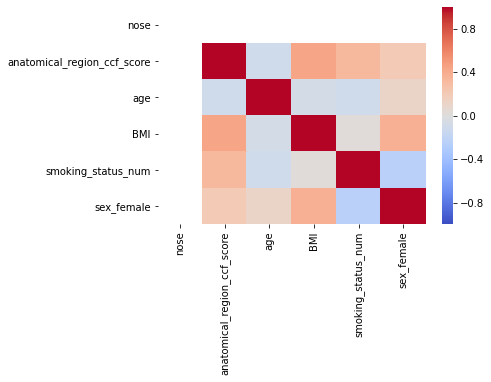

subject VIFs:
   VIF Factor            features
0    1.031916                 age
1    1.086915                 BMI
2    1.038825  smoking_status_num
3    1.103258          sex_female


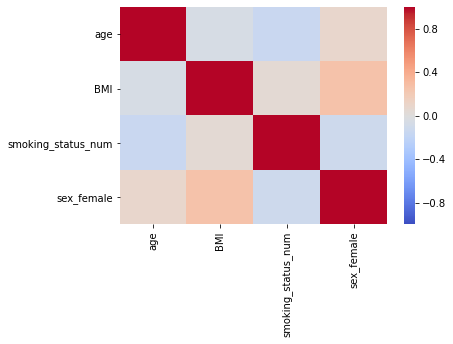

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation AT2...
setting subadata.X to raw counts
subadata shape: (62175, 28527)
subadata shape after gene filtering: (62175, 17968)
creating directory: ../../results/covariate_modeling/test_input/AT2
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 98
number of samples to remove because of low number of cells: 16
Number of samples after filtering: 82
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 9
Number of datasets to remove because of fewer than 2 subjects: 2
{'Barbry_Leroy_2020', 'Lafyatis_Rojas_2019_10Xv1'}
Number of datasets after filtering: 7 

Number of samples before filtering: 82
Number of sampl

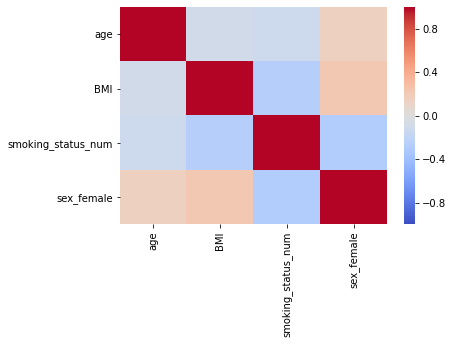

subject VIFs:
   VIF Factor            features
0    1.080213                 age
1    1.031857                 BMI
2    1.028615  smoking_status_num
3    1.076815          sex_female


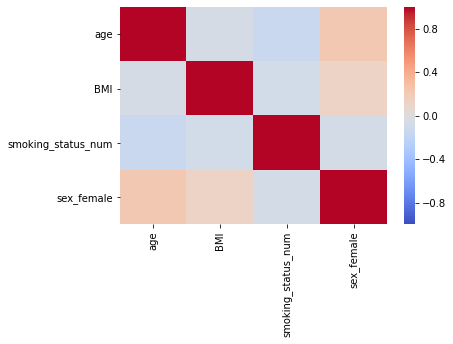

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Basal...
setting subadata.X to raw counts
subadata shape: (84713, 28527)
subadata shape after gene filtering: (84713, 20936)
creating directory: ../../results/covariate_modeling/test_input/Basal
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 131
number of samples to remove because of low number of cells: 44
Number of samples after filtering: 87
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 10
Number of datasets to remove because of fewer than 2 subjects: 0
set()
Number of datasets after filtering: 10 

Number of samples before filtering: 87
Number of samples after filtering: 87
#3: take out un

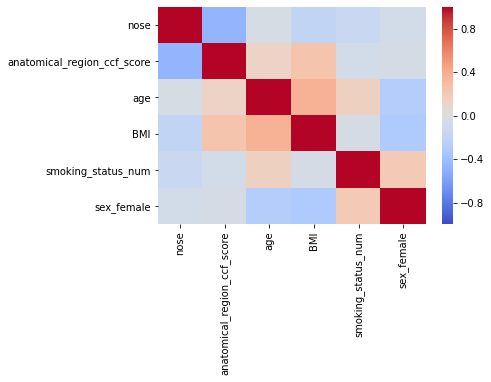

subject VIFs:
   VIF Factor            features
0    1.179241                 age
1    1.142096                 BMI
2    1.052612  smoking_status_num
3    1.124822          sex_female


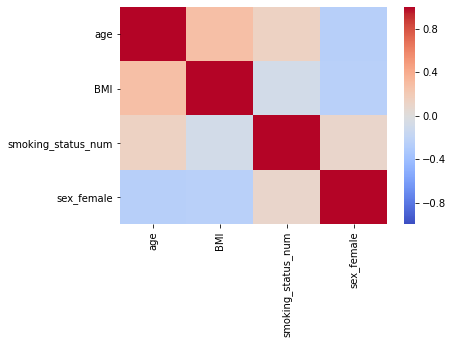

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation EC venous...
setting subadata.X to raw counts
subadata shape: (12975, 28527)
subadata shape after gene filtering: (12975, 13447)
creating directory: ../../results/covariate_modeling/test_input/EC_venous
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 118
number of samples to remove because of low number of cells: 23
Number of samples after filtering: 95
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 10
Number of datasets to remove because of fewer than 2 subjects: 2
{'Lafyatis_Rojas_2019_10Xv1', 'Misharin_2021'}
Number of datasets after filtering: 8 

Number of samples before filtering: 95
Numbe

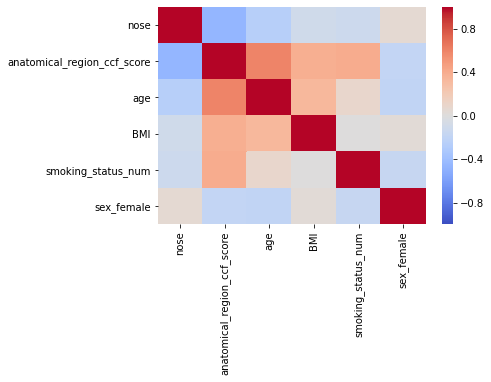

subject VIFs:
   VIF Factor            features
0    1.121794                 age
1    1.108878                 BMI
2    1.043610  smoking_status_num
3    1.055576          sex_female


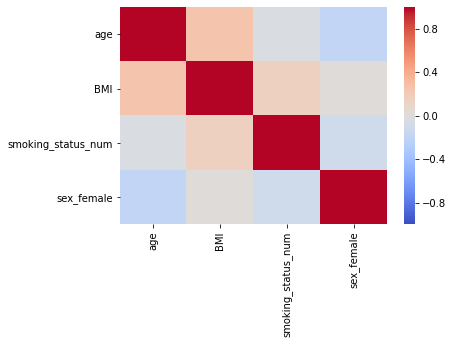

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation T cell lineage...
setting subadata.X to raw counts
subadata shape: (50859, 28527)
subadata shape after gene filtering: (50859, 15390)
creating directory: ../../results/covariate_modeling/test_input/T_cell_lineage
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 143
number of samples to remove because of low number of cells: 38
Number of samples after filtering: 105
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 12
Number of datasets to remove because of fewer than 2 subjects: 0
set()
Number of datasets after filtering: 12 

Number of samples before filtering: 105
Number of samples after filtering

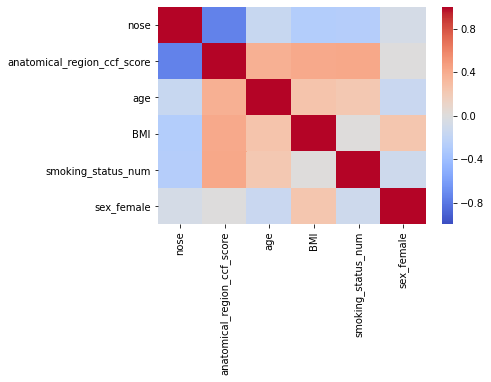

subject VIFs:
   VIF Factor            features
0    1.102739                 age
1    1.067242                 BMI
2    1.027143  smoking_status_num
3    1.050012          sex_female


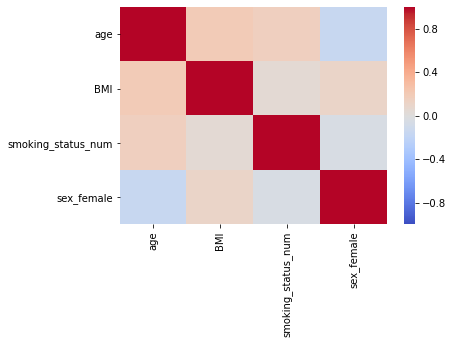

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation EC arterial...
setting subadata.X to raw counts
subadata shape: (7391, 28527)
subadata shape after gene filtering: (7391, 12222)
creating directory: ../../results/covariate_modeling/test_input/EC_arterial
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 107
number of samples to remove because of low number of cells: 44
Number of samples after filtering: 63
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 10
Number of datasets to remove because of fewer than 2 subjects: 3
{'Lafyatis_Rojas_2019_10Xv1', 'Misharin_2021', 'Teichmann_Meyer_2019'}
Number of datasets after filtering: 7 

Number of samples 

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


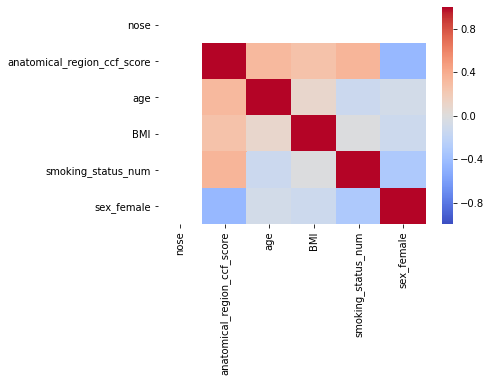

subject VIFs:
   VIF Factor            features
0    1.071315                 age
1    1.008783                 BMI
2    1.136804  smoking_status_num
3    1.093561          sex_female


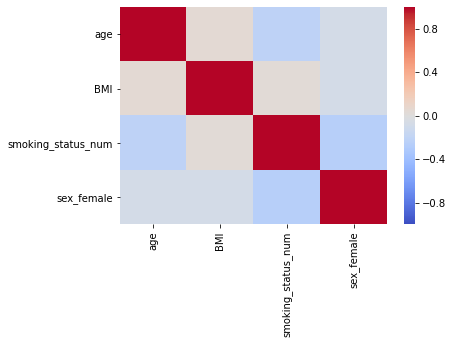

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Peribronchial fibroblasts...
setting subadata.X to raw counts
subadata shape: (1573, 28527)
subadata shape after gene filtering: (1573, 8837)
creating directory: ../../results/covariate_modeling/test_input/Peribronchial_fibroblasts
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 86
number of samples to remove because of low number of cells: 59
Number of samples after filtering: 27
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 7
Number of datasets to remove because of fewer than 2 subjects: 3
{'Jain_Misharin_2021_10Xv2', 'Krasnow_2020', 'Jain_Misharin_2021_10Xv1'}
Number of datasets after filter

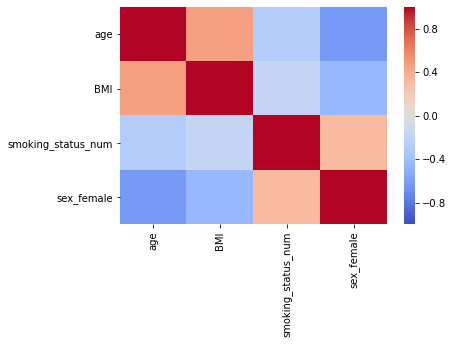

subject VIFs:
   VIF Factor            features
0    1.711360                 age
1    1.321337                 BMI
2    1.059884  smoking_status_num
3    1.660449          sex_female


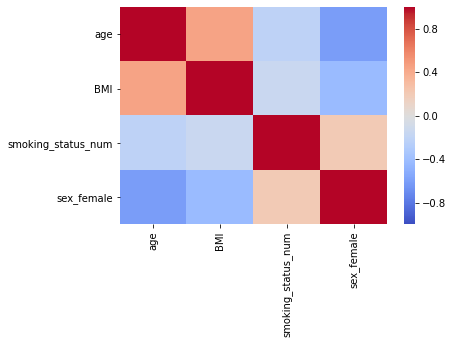

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation AT1...
setting subadata.X to raw counts
subadata shape: (7937, 28527)
subadata shape after gene filtering: (7937, 11939)
creating directory: ../../results/covariate_modeling/test_input/AT1
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 88
number of samples to remove because of low number of cells: 39
Number of samples after filtering: 49
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 7
Number of datasets to remove because of fewer than 2 subjects: 2
{'Barbry_Leroy_2020', 'Meyer_2019'}
Number of datasets after filtering: 5 

Number of samples before filtering: 49
Number of samples after filterin

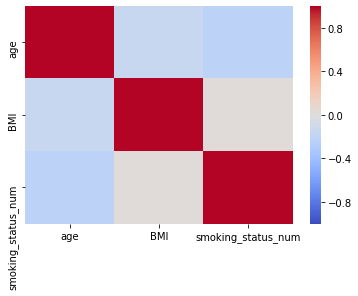

subject VIFs:
   VIF Factor            features
0    1.196684                 age
1    1.021239                 BMI
2    1.179337  smoking_status_num


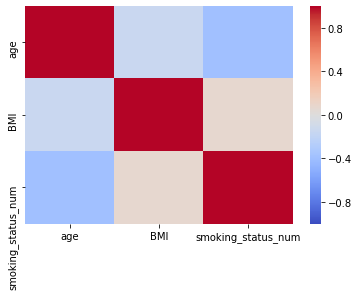

storing set of groups for cat sex
['male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Multiciliated...
setting subadata.X to raw counts
subadata shape: (41098, 28527)
subadata shape after gene filtering: (41098, 19423)
creating directory: ../../results/covariate_modeling/test_input/Multiciliated
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 153
number of samples to remove because of low number of cells: 24
Number of samples after filtering: 129
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 14
Number of datasets to remove because of fewer than 2 subjects: 1
{'Lafyatis_Rojas_2019_10Xv1'}
Number of datasets after filtering: 13 

Number of samples before filtering: 129
Number of samples aft

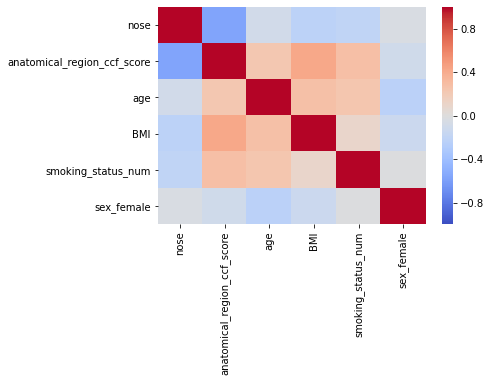

subject VIFs:
   VIF Factor            features
0    1.050460                 age
1    1.025870                 BMI
2    1.020360  smoking_status_num
3    1.035521          sex_female


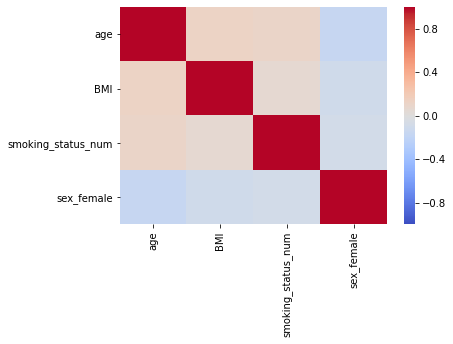

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Plasma cells...
setting subadata.X to raw counts
subadata shape: (1773, 28527)
subadata shape after gene filtering: (1773, 9131)
creating directory: ../../results/covariate_modeling/test_input/Plasma_cells
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 101
number of samples to remove because of low number of cells: 65
Number of samples after filtering: 36
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 8
Number of datasets to remove because of fewer than 2 subjects: 0
set()
Number of datasets after filtering: 8 

Number of samples before filtering: 36
Number of samples after filtering: 36
#3: ta

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


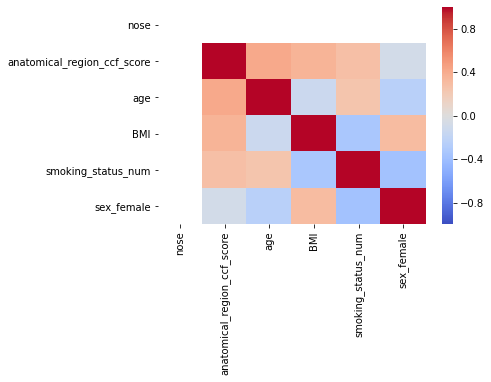

subject VIFs:
   VIF Factor            features
0    1.021043                 age
1    1.191586                 BMI
2    1.182653  smoking_status_num
3    1.045448          sex_female


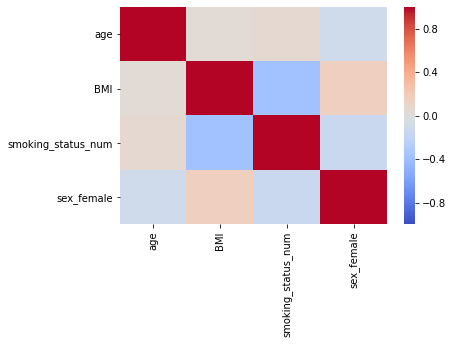

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Secretory...
setting subadata.X to raw counts
subadata shape: (76582, 28527)
subadata shape after gene filtering: (76582, 19636)
creating directory: ../../results/covariate_modeling/test_input/Secretory
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 148
number of samples to remove because of low number of cells: 46
Number of samples after filtering: 102
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 12
Number of datasets to remove because of fewer than 2 subjects: 2
{'Misharin_Budinger_2018', 'Meyer_2019'}
Number of datasets after filtering: 10 

Number of samples before filtering: 102
Number o

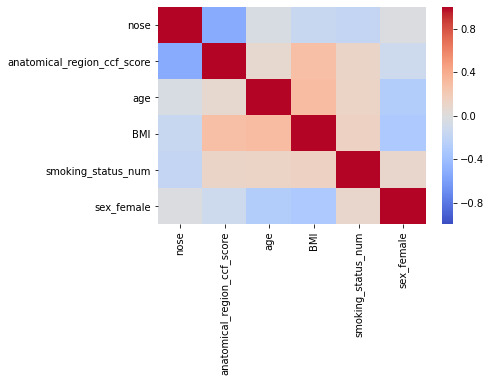

subject VIFs:
   VIF Factor            features
0    1.069235                 age
1    1.110904                 BMI
2    1.019539  smoking_status_num
3    1.103597          sex_female


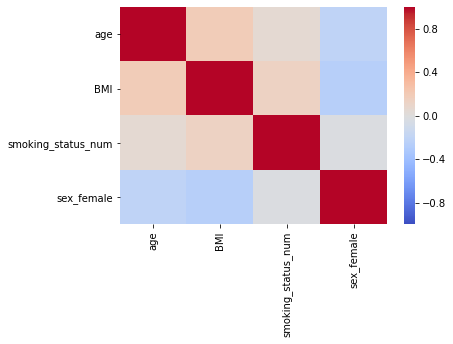

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Smooth muscle...
setting subadata.X to raw counts
subadata shape: (3552, 28527)
subadata shape after gene filtering: (3552, 11428)
creating directory: ../../results/covariate_modeling/test_input/Smooth_muscle
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 104
number of samples to remove because of low number of cells: 58
Number of samples after filtering: 46
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 9
Number of datasets to remove because of fewer than 2 subjects: 2
{'Misharin_Budinger_2018', 'Teichmann_Meyer_2019'}
Number of datasets after filtering: 7 

Number of samples before filtering:

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


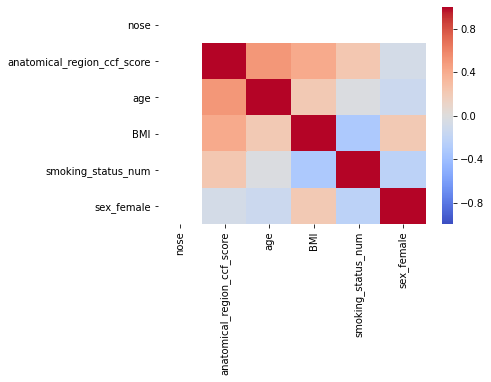

subject VIFs:
   VIF Factor            features
0    1.235281                 age
1    1.150839                 BMI
2    1.052390  smoking_status_num
3    1.175385          sex_female


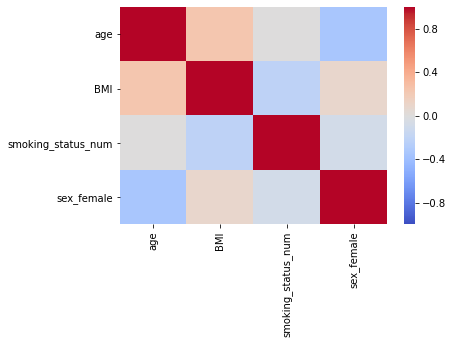

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Monocytes...
setting subadata.X to raw counts
subadata shape: (26529, 28527)
subadata shape after gene filtering: (26529, 14198)
creating directory: ../../results/covariate_modeling/test_input/Monocytes
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 130
number of samples to remove because of low number of cells: 39
Number of samples after filtering: 91
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 11
Number of datasets to remove because of fewer than 2 subjects: 2
{'Barbry_Leroy_2020', 'Jain_Misharin_2021_10Xv2'}
Number of datasets after filtering: 9 

Number of samples before filtering: 91
Nu

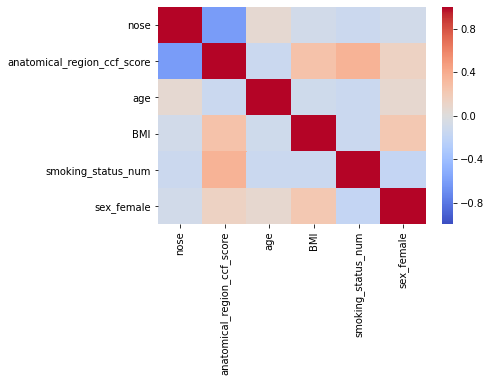

subject VIFs:
   VIF Factor            features
0    1.047262                 age
1    1.040371                 BMI
2    1.024748  smoking_status_num
3    1.033454          sex_female


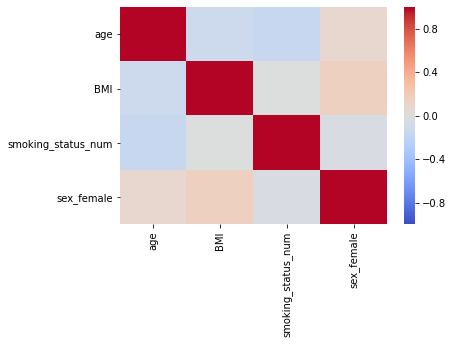

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Monocyte-derived Mφ...
setting subadata.X to raw counts
subadata shape: (28223, 28527)
subadata shape after gene filtering: (28223, 14957)
creating directory: ../../results/covariate_modeling/test_input/Monocyte-derived_Mφ
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 121
number of samples to remove because of low number of cells: 33
Number of samples after filtering: 88
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 11
Number of datasets to remove because of fewer than 2 subjects: 2
{'Jain_Misharin_2021_10Xv2', 'Nawijn_2021'}
Number of datasets after filtering: 9 

Number of samples before fi

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


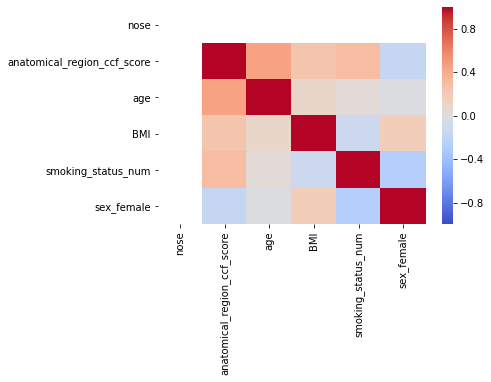

subject VIFs:
   VIF Factor            features
0    1.025610                 age
1    1.029114                 BMI
2    1.025297  smoking_status_num
3    1.027563          sex_female


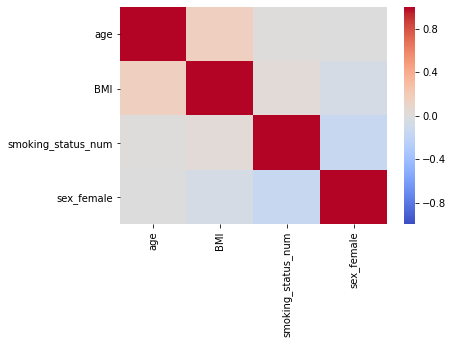

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation SMG serous...
setting subadata.X to raw counts
subadata shape: (2889, 28527)
subadata shape after gene filtering: (2889, 8044)
creating directory: ../../results/covariate_modeling/test_input/SMG_serous
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 30
number of samples to remove because of low number of cells: 11
Number of samples after filtering: 19
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 4
Number of datasets to remove because of fewer than 2 subjects: 2
{'Krasnow_2020', 'Misharin_2021'}
Number of datasets after filtering: 2 

Number of samples before filtering: 19
Number of samples aft

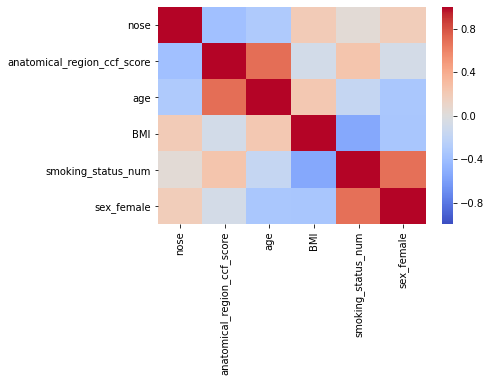

subject VIFs:
   VIF Factor            features
0    1.191216                 age
1    1.224759                 BMI
2    2.082418  smoking_status_num
3    2.116170          sex_female


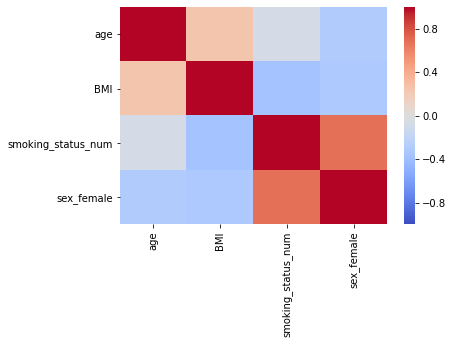

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation EC capillary...
setting subadata.X to raw counts
subadata shape: (23205, 28527)
subadata shape after gene filtering: (23205, 13381)
creating directory: ../../results/covariate_modeling/test_input/EC_capillary
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 90
number of samples to remove because of low number of cells: 37
Number of samples after filtering: 53
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 8
Number of datasets to remove because of fewer than 2 subjects: 2
{'Misharin_Budinger_2018', 'Teichmann_Meyer_2019'}
Number of datasets after filtering: 6 

Number of samples before filtering: 

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


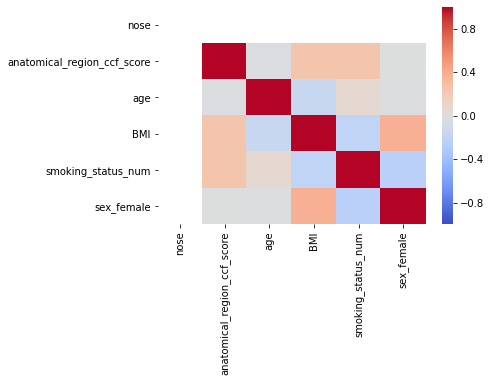

subject VIFs:
   VIF Factor            features
0    1.009374                 age
1    1.109906                 BMI
2    1.010533  smoking_status_num
3    1.112470          sex_female


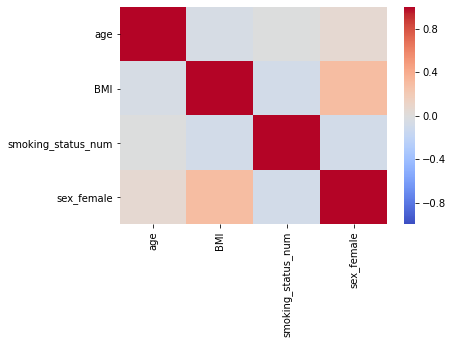

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Adventitial fibroblasts...
setting subadata.X to raw counts
subadata shape: (10321, 28527)
subadata shape after gene filtering: (10321, 15149)
creating directory: ../../results/covariate_modeling/test_input/Adventitial_fibroblasts
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 96
number of samples to remove because of low number of cells: 47
Number of samples after filtering: 49
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 7
Number of datasets to remove because of fewer than 2 subjects: 0
set()
Number of datasets after filtering: 7 

Number of samples before filtering: 49
Number of samples af

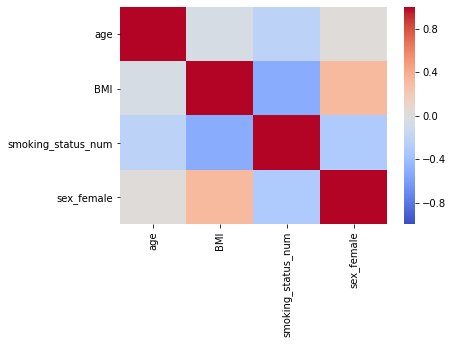

subject VIFs:
   VIF Factor            features
0    1.177291                 age
1    1.151456                 BMI
2    1.331076  smoking_status_num
3    1.030692          sex_female


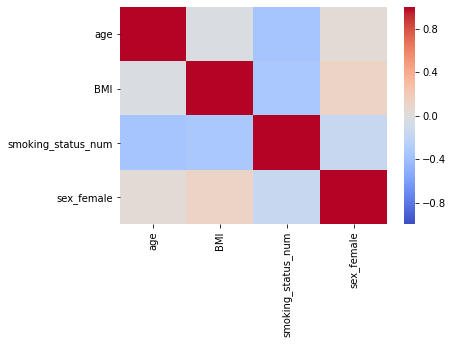

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Lymphatic EC...
setting subadata.X to raw counts
subadata shape: (4595, 28527)
subadata shape after gene filtering: (4595, 11380)
creating directory: ../../results/covariate_modeling/test_input/Lymphatic_EC
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 94
number of samples to remove because of low number of cells: 45
Number of samples after filtering: 49
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 9
Number of datasets to remove because of fewer than 2 subjects: 1
{'Barbry_Leroy_2020'}
Number of datasets after filtering: 8 

Number of samples before filtering: 49
Number of samples after filt

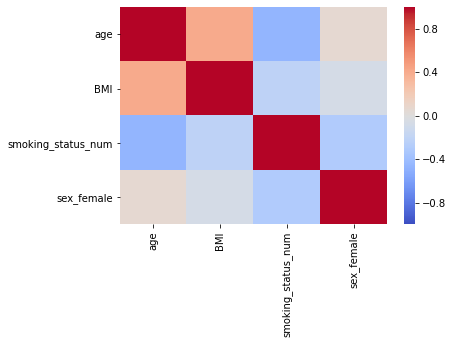

subject VIFs:
   VIF Factor            features
0    1.481187                 age
1    1.129535                 BMI
2    1.440934  smoking_status_num
3    1.073225          sex_female


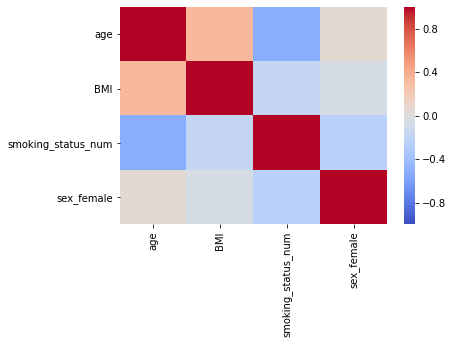

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Alveolar fibroblasts...
setting subadata.X to raw counts
subadata shape: (5182, 28527)
subadata shape after gene filtering: (5182, 12794)
creating directory: ../../results/covariate_modeling/test_input/Alveolar_fibroblasts
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 84
number of samples to remove because of low number of cells: 44
Number of samples after filtering: 40
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 8
Number of datasets to remove because of fewer than 2 subjects: 2
{'Teichmann_Meyer_2019', 'Nawijn_2021'}
Number of datasets after filtering: 6 

Number of samples before filterin

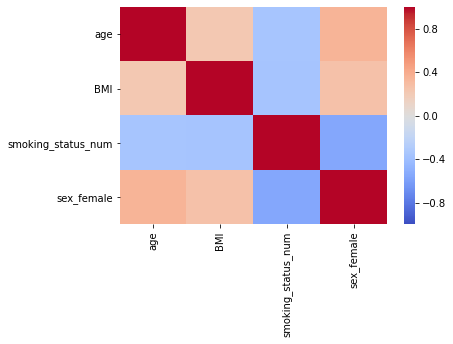

subject VIFs:
   VIF Factor            features
0    1.281591                 age
1    1.100926                 BMI
2    1.517249  smoking_status_num
3    1.348651          sex_female


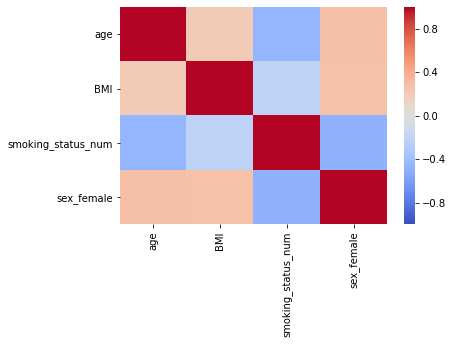

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Neuroendocrine...
setting subadata.X to raw counts
subadata shape: (159, 28527)
subadata shape after gene filtering: (159, 5408)
creating directory: ../../results/covariate_modeling/test_input/Neuroendocrine
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 41
number of samples to remove because of low number of cells: 37
Number of samples after filtering: 4
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 4
Number of datasets to remove because of fewer than 2 subjects: 4
{'Barbry_Leroy_2020', 'Krasnow_2020', 'Seibold_2020_10Xv3', 'Seibold_2020_10Xv2'}
Number of datasets after filtering: 0 

Number 

../../scripts/LCA_GLMM_data_filtering.py:64: RuntimeWarning: invalid value encountered in long_scalars
  na_prop = [data_per_sample_df[cat].isnull().sum() / n_samples for cat in cats]


setting subadata.X to raw counts
subadata shape: (9133, 28527)
subadata shape after gene filtering: (9133, 13029)
creating directory: ../../results/covariate_modeling/test_input/DC2
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 143
number of samples to remove because of low number of cells: 33
Number of samples after filtering: 110
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 12
Number of datasets to remove because of fewer than 2 subjects: 2
{'Lafyatis_Rojas_2019_10Xv1', 'Jain_Misharin_2021_10Xv1'}
Number of datasets after filtering: 10 

Number of samples before filtering: 110
Number of samples after filtering: 106
#3: take out under-annotated categories:
Number of cats fully annotated: 3
['anatomical_region_ccf_score', 'nose', 'sex']
Number of cats with at least fraction 0.5 annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex', 'smoking_status_num']
Number of cats not s

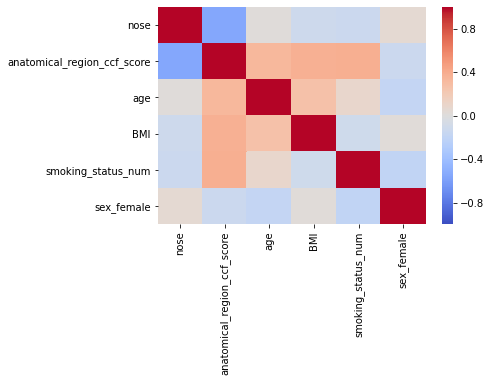

subject VIFs:
   VIF Factor            features
0    1.090050                 age
1    1.041569                 BMI
2    1.023376  smoking_status_num
3    1.072149          sex_female


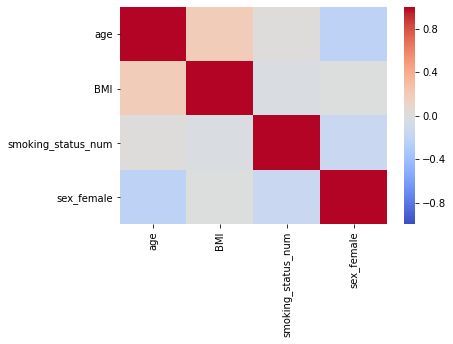

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Transitional Club-AT2...
setting subadata.X to raw counts
subadata shape: (3975, 28527)
subadata shape after gene filtering: (3975, 12115)
creating directory: ../../results/covariate_modeling/test_input/Transitional_Club-AT2
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 91
number of samples to remove because of low number of cells: 48
Number of samples after filtering: 43
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 7
Number of datasets to remove because of fewer than 2 subjects: 2
{'Teichmann_Meyer_2019', 'Meyer_2019'}
Number of datasets after filtering: 5 

Number of samples before filteri

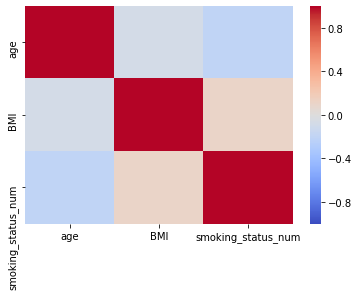

subject VIFs:
   VIF Factor            features
0    1.058218                 age
1    1.025153                 BMI
2    1.080628  smoking_status_num


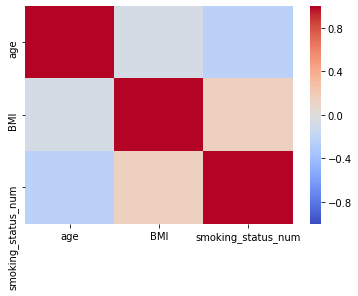

storing set of groups for cat sex
['male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation DC1...
setting subadata.X to raw counts
subadata shape: (322, 28527)
subadata shape after gene filtering: (322, 4256)
creating directory: ../../results/covariate_modeling/test_input/DC1
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 72
number of samples to remove because of low number of cells: 63
Number of samples after filtering: 9
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 5
Number of datasets to remove because of fewer than 2 subjects: 4
{'Krasnow_2020', 'Meyer_2019', 'Misharin_2021', 'Nawijn_2021'}
Number of datasets after filtering: 1 

Number of samples before filtering: 9
Number of samples af

../../scripts/LCA_GLMM_data_filtering.py:64: RuntimeWarning: invalid value encountered in long_scalars
  na_prop = [data_per_sample_df[cat].isnull().sum() / n_samples for cat in cats]


setting subadata.X to raw counts
subadata shape: (716, 28527)
subadata shape after gene filtering: (716, 6184)
creating directory: ../../results/covariate_modeling/test_input/Myofibroblasts
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 54
number of samples to remove because of low number of cells: 40
Number of samples after filtering: 14
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 5
Number of datasets to remove because of fewer than 2 subjects: 2
{'Meyer_2019', 'Lafyatis_Rojas_2019_10Xv2'}
Number of datasets after filtering: 3 

Number of samples before filtering: 14
Number of samples after filtering: 11
#3: take out under-annotated categories:
Number of cats fully annotated: 4
['age', 'anatomical_region_ccf_score', 'nose', 'sex']
Number of cats with at least fraction 0.5 annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex', 'smoking_status_num']
Number of cats not suffic

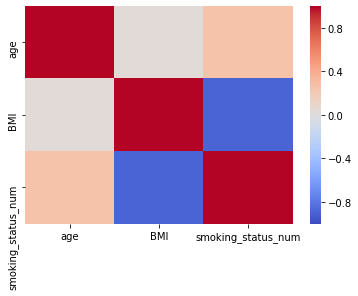

subject VIFs:
   VIF Factor            features
0    1.442914                 age
1    8.313763                 BMI
2    8.441896  smoking_status_num


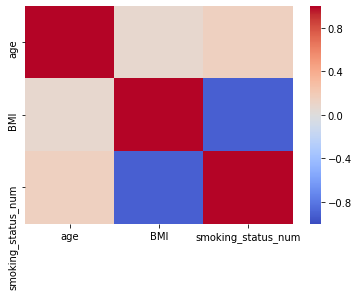

CHECK OUT YOUR vifs_per_subject!! THEY'RE QUITE HIGH! We will not continue with modeling here.


Subsetting to cells with manual annotation B cell...
setting subadata.X to raw counts
subadata shape: (4511, 28527)
subadata shape after gene filtering: (4511, 10075)
creating directory: ../../results/covariate_modeling/test_input/B_cell
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 107
number of samples to remove because of low number of cells: 53
Number of samples after filtering: 54
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 11
Number of datasets to remove because of fewer than 2 subjects: 3
{'Misharin_Budinger_2018', 'Jain_Misharin_2021_10Xv1', 'Misharin_2021'}
Number of datasets after filtering: 8 

Number of samples before filtering: 54
Number of samples after filtering: 49
#3: take out under-annotated categories:
Number of cats fully annotated: 4
['age', 'anatomical_region_ccf_score', 'no

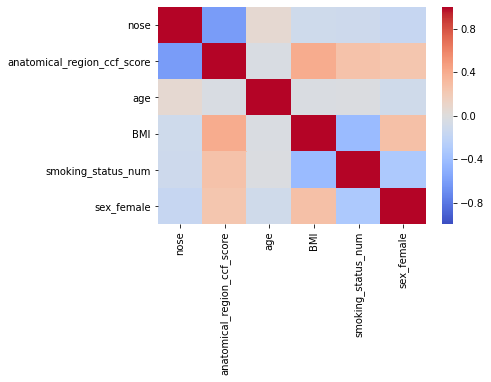

subject VIFs:
   VIF Factor            features
0    1.030573                 age
1    1.112140                 BMI
2    1.127459  smoking_status_num
3    1.041605          sex_female


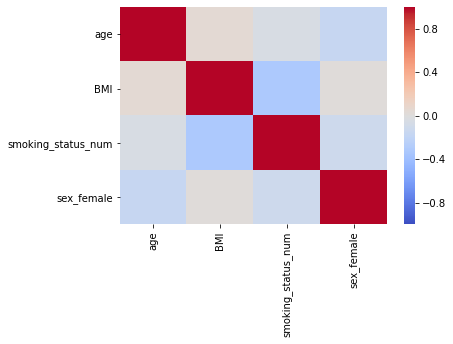

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Mast cells...
setting subadata.X to raw counts
subadata shape: (6623, 28527)
subadata shape after gene filtering: (6623, 10782)
creating directory: ../../results/covariate_modeling/test_input/Mast_cells
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 113
number of samples to remove because of low number of cells: 53
Number of samples after filtering: 60
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 12
Number of datasets to remove because of fewer than 2 subjects: 4
{'Lafyatis_Rojas_2019_10Xv1', 'Jain_Misharin_2021_10Xv1', 'Teichmann_Meyer_2019', 'Misharin_2021'}
Number of datasets after filteri

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+87.g52b142c-py3.7-linux-x86_64.egg/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


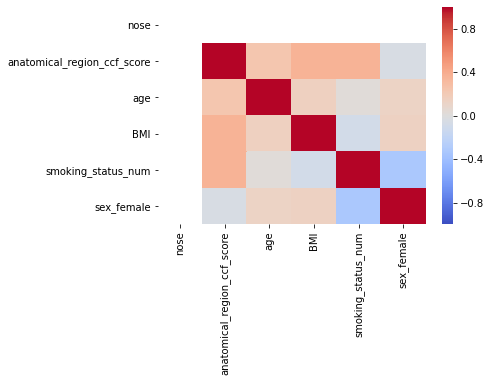

subject VIFs:
   VIF Factor            features
0    1.010017                 age
1    1.032962                 BMI
2    1.050289  smoking_status_num
3    1.070688          sex_female


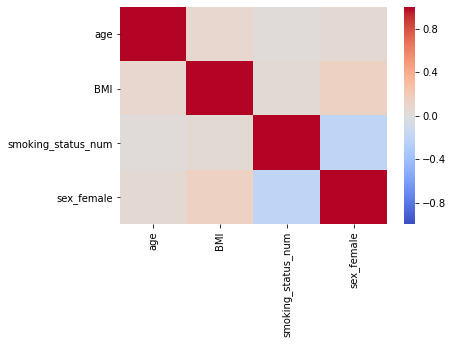

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Interstitial Mφ perivascular...
setting subadata.X to raw counts
subadata shape: (4805, 28527)
subadata shape after gene filtering: (4805, 11132)
creating directory: ../../results/covariate_modeling/test_input/Interstitial_Mφ_perivascular
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 104
number of samples to remove because of low number of cells: 45
Number of samples after filtering: 59
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 9
Number of datasets to remove because of fewer than 2 subjects: 1
{'Lafyatis_Rojas_2019_10Xv1'}
Number of datasets after filtering: 8 

Number of samples before f

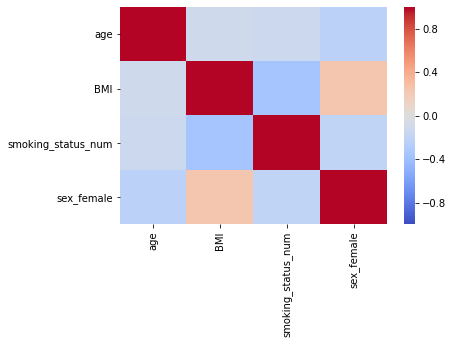

subject VIFs:
   VIF Factor            features
0    1.061905                 age
1    1.023774                 BMI
2    1.091020  smoking_status_num
3    1.014848          sex_female


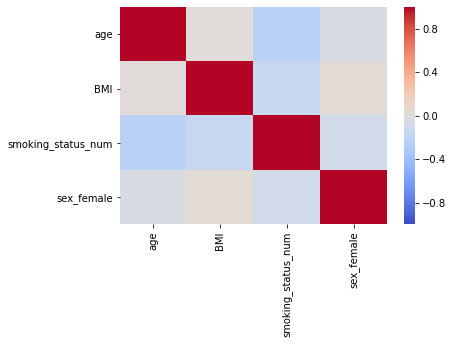

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation SMG mucous...
setting subadata.X to raw counts
subadata shape: (537, 28527)
subadata shape after gene filtering: (537, 4312)
creating directory: ../../results/covariate_modeling/test_input/SMG_mucous
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 30
number of samples to remove because of low number of cells: 20
Number of samples after filtering: 10
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 3
Number of datasets to remove because of fewer than 2 subjects: 1
{'Misharin_2021'}
Number of datasets after filtering: 2 

Number of samples before filtering: 10
Number of samples after filtering: 9
#3

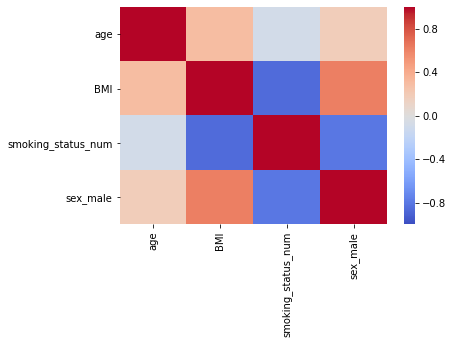

subject VIFs:
   VIF Factor            features
0    1.602563                 age
1    4.619415                 BMI
2    7.788986  smoking_status_num
3    3.143181            sex_male


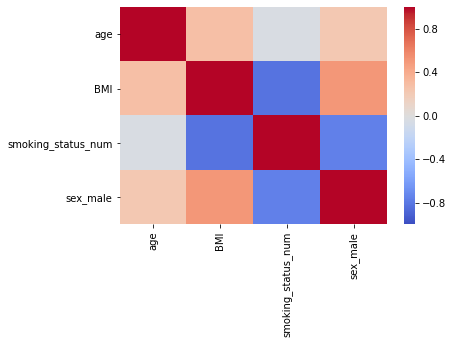

CHECK OUT YOUR vifs_per_subject!! THEY'RE QUITE HIGH! We will not continue with modeling here.


Subsetting to cells with manual annotation Pericytes...
setting subadata.X to raw counts
subadata shape: (3032, 28527)
subadata shape after gene filtering: (3032, 10004)
creating directory: ../../results/covariate_modeling/test_input/Pericytes
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 44
number of samples to remove because of low number of cells: 28
Number of samples after filtering: 16
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 4
Number of datasets to remove because of fewer than 2 subjects: 1
{'Meyer_2019'}
Number of datasets after filtering: 3 

Number of samples before filtering: 16
Number of samples after filtering: 15
#3: take out under-annotated categories:
Number of cats fully annotated: 4
['age', 'anatomical_region_ccf_score', 'nose', 'sex']
Number of cats with at least fraction 0.5

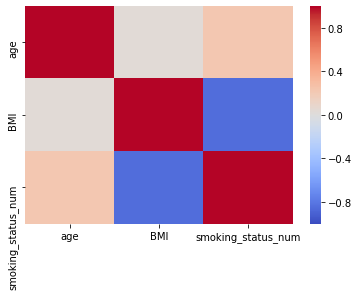

subject VIFs:
   VIF Factor            features
0    1.233400                 age
1    4.570768                 BMI
2    4.643945  smoking_status_num


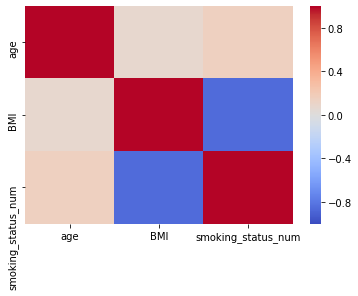

storing set of groups for cat sex
['male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation SMG duct...
setting subadata.X to raw counts
subadata shape: (1274, 28527)
subadata shape after gene filtering: (1274, 11755)
creating directory: ../../results/covariate_modeling/test_input/SMG_duct
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 63
number of samples to remove because of low number of cells: 32
Number of samples after filtering: 31
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 5
Number of datasets to remove because of fewer than 2 subjects: 1
{'Misharin_2021'}
Number of datasets after filtering: 4 

Number of samples before filtering: 31
Number of samples after filtering: 30
#3: take out

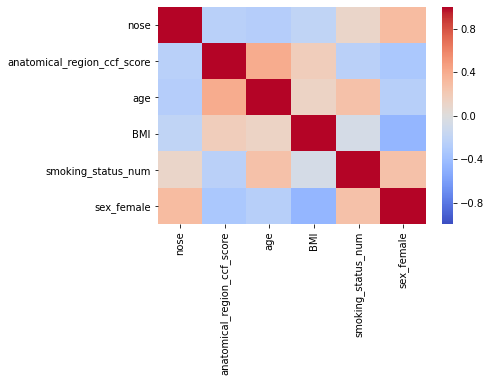

subject VIFs:
   VIF Factor            features
0    1.240267                 age
1    1.186789                 BMI
2    1.218873  smoking_status_num
3    1.403260          sex_female


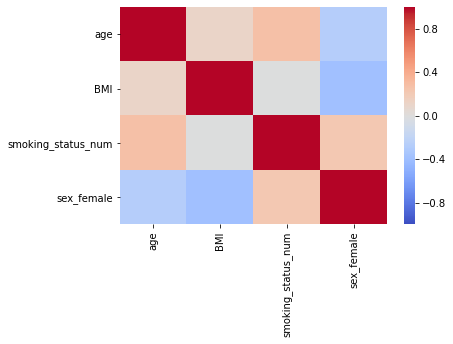

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Mesothelium...
setting subadata.X to raw counts
subadata shape: (230, 28527)
subadata shape after gene filtering: (230, 3783)
creating directory: ../../results/covariate_modeling/test_input/Mesothelium
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 27
number of samples to remove because of low number of cells: 21
Number of samples after filtering: 6
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 3
Number of datasets to remove because of fewer than 2 subjects: 2
{'Krasnow_2020', 'Teichmann_Meyer_2019'}
Number of datasets after filtering: 1 

Number of samples before filtering: 6
Number of sample

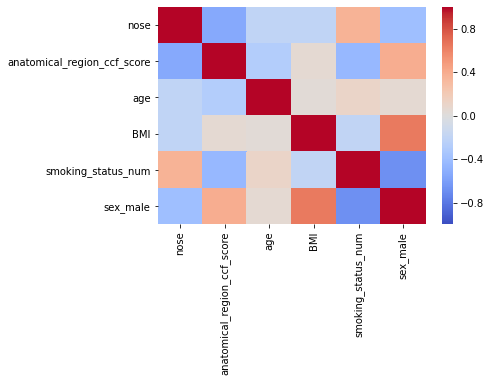

subject VIFs:
   VIF Factor            features
0    1.070723                 age
1    2.070578                 BMI
2    2.139290  smoking_status_num
3    3.362322          sex_female


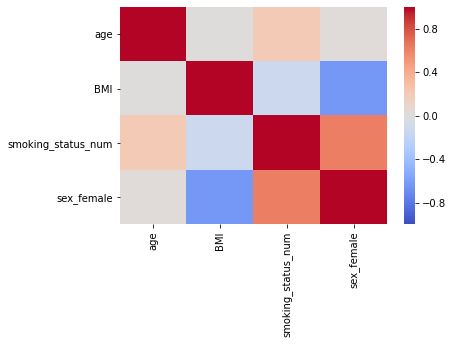

storing set of groups for cat sex
['female', 'male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Fibromyocytes...
setting subadata.X to raw counts
subadata shape: (335, 28527)
subadata shape after gene filtering: (335, 1786)
creating directory: ../../results/covariate_modeling/test_input/Fibromyocytes
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 32
number of samples to remove because of low number of cells: 24
Number of samples after filtering: 8
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 2
Number of datasets to remove because of fewer than 2 subjects: 1
{'Meyer_2019'}
Number of datasets after filtering: 1 

Number of samples before filtering: 8
Number of samples after filtering: 6
#

../../scripts/LCA_GLMM_data_filtering.py:64: RuntimeWarning: invalid value encountered in long_scalars
  na_prop = [data_per_sample_df[cat].isnull().sum() / n_samples for cat in cats]


setting subadata.X to raw counts
subadata shape: (552, 28527)
subadata shape after gene filtering: (552, 4111)
creating directory: ../../results/covariate_modeling/test_input/Plasmacytoid_DCs
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 59
number of samples to remove because of low number of cells: 47
Number of samples after filtering: 12
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 5
Number of datasets to remove because of fewer than 2 subjects: 2
{'Misharin_2021', 'Nawijn_2021'}
Number of datasets after filtering: 3 

Number of samples before filtering: 12
Number of samples after filtering: 10
#3: take out under-annotated categories:
Number of cats fully annotated: 5
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex']
Number of cats with at least fraction 0.5 annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex', 'smoking_status_num']
Number of cats not sufficie

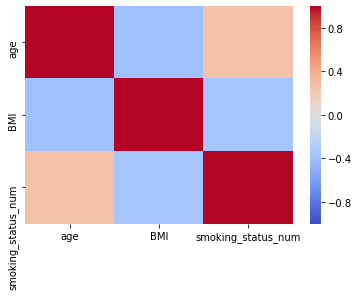

subject VIFs:
   VIF Factor            features
0    1.250519                 age
1    1.444050                 BMI
2    1.174863  smoking_status_num


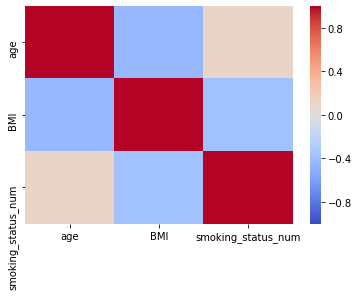

storing set of groups for cat sex
['male']
rescaling age by setting 10th perc (25.0) to 0, and 90th perc (64.0) to 1.
rescaling BMI by setting 10th perc (21.32) to 0, and 90th perc (36.86) to 1.
Storing gene sums per sample and design matrix...
Done!



Subsetting to cells with manual annotation Subpleural fibroblasts...
setting subadata.X to raw counts
subadata shape: (276, 28527)
subadata shape after gene filtering: (276, 4718)
creating directory: ../../results/covariate_modeling/test_input/Subpleural_fibroblasts
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 20
number of samples to remove because of low number of cells: 15
Number of samples after filtering: 5
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 4
Number of datasets to remove because of fewer than 2 subjects: 4
{'Krasnow_2020', 'Teichmann_Meyer_2019', 'Meyer_2019', 'Banovich_Kropski_2020'}
Number of datasets after filtering: 0 

Num

../../scripts/LCA_GLMM_data_filtering.py:64: RuntimeWarning: invalid value encountered in long_scalars
  na_prop = [data_per_sample_df[cat].isnull().sum() / n_samples for cat in cats]


setting subadata.X to raw counts
subadata shape: (312, 28527)
subadata shape after gene filtering: (312, 3240)
creating directory: ../../results/covariate_modeling/test_input/Migratory_DCs
Starting filtering of samples...
ROUND 1
#1: filter on n_cells per sample:
Number of samples before filtering: 76
number of samples to remove because of low number of cells: 67
Number of samples after filtering: 9
#2: filter on n_subjects per dataset:
Number of datasets before filtering: 5
Number of datasets to remove because of fewer than 2 subjects: 3
{'Meyer_2019', 'Teichmann_Meyer_2019', 'Lafyatis_Rojas_2019_10Xv2'}
Number of datasets after filtering: 2 

Number of samples before filtering: 9
Number of samples after filtering: 4
#3: take out under-annotated categories:
Number of cats fully annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex', 'smoking_status_num']
Number of cats with at least fraction 0.5 annotated: 6
['BMI', 'age', 'anatomical_region_ccf_score', 'nose', 'sex'

In [15]:
for celltype in adata.obs.manual_ann_grouped.unique():
    print(f"Subsetting to cells with manual annotation {celltype}...")
    subadata = adata[adata.obs.manual_ann_grouped == celltype, :].copy()
    print("setting subadata.X to raw counts")
    subadata.X = subadata.layers["counts"]
    print("subadata shape:", subadata.shape)
    sc.pp.filter_genes(subadata, min_cells=min_n_cells_per_gene)
    print("subadata shape after gene filtering:", subadata.shape)
    # prepare data:
    #  categories.
    # NOTE: this order will also be used for the modeling!
    # NOTE 2: we excluded ethnicity here, for reasons outlined above.
    # add back in as soon as we have sufficient ethnicity data.
    cats_unf = [
        "nose",
        "anatomical_region_ccf_score",
        "sex",
        "age",
        "BMI",
        "smoking_status_num",
        "dataset",
        "subject_ID",
        "sample",
    ]
    # set dir_output_ct. Use cell type name without spaces
    celltype_no_spaces = celltype.replace(" ", "_")
    dir_output_ct = os.path.join(dir_output, celltype_no_spaces)
    if not os.path.exists(dir_output_ct):
        print("creating directory:", dir_output_ct)
        os.makedirs(dir_output_ct)
    # set up dataframe that shows these categories for every sample
    agg_dict = {cat: "first" for cat in cats_unf}
    agg_dict["sample"] = "count"
    data_per_sample = subadata.obs.groupby("sample").agg(agg_dict)
    data_per_sample.rename(columns={"sample": "n_cells"}, inplace=True)
    # and store subject level annotations, adata-wide:
    adata_wide_subject_overview = (
        adata.obs.groupby("subject_ID")
        .agg(agg_dict)
        .drop(columns=["anatomical_region_ccf_score", "nose", "sample", "subject_ID"])
    )
    # now filter out samples/categories/datasets that do not fulfill our paramater-based requirements:
    print("Starting filtering of samples...")
    round = 1
    sample_count_before = data_per_sample.shape[0]
    sample_count_after = 0
    while sample_count_before > sample_count_after:
        print("ROUND", round)
        sample_count_before = data_per_sample.shape[0]
        print("#1: filter on n_cells per sample:")
        data_per_sample = LCA_GLMM_data_filtering.filter_based_on_n_cells_per_sample(
            data_per_sample, min_n_cells_per_sample
        )
        print("#2: filter on n_subjects per dataset:")
        data_per_sample = (
            LCA_GLMM_data_filtering.filter_based_on_n_subjects_per_dataset(
                data_per_sample, min_n_subj_per_dataset
            )
        )
        print("#3: take out under-annotated categories:")
        (
            cats_full_ann,
            cats_suff_ann,
            cats_under_ann,
        ) = LCA_GLMM_data_filtering.annotated_proportion_checker(
            data_per_sample, min_prop_ann
        )
        print("#4: take out samples that lack annotation:")
        data_per_sample = LCA_GLMM_data_filtering.filter_unannotated_samples(
            data_per_sample, cats_suff_ann
        )
        print("#5: take out representatives of groups that have too few members:")
        data_per_sample = LCA_GLMM_data_filtering.filter_underrepresented_groups(
            data_per_sample, min_inst_per_group
        )
        sample_count_after = data_per_sample.shape[0]
        round += 1
    # print outcome of filtering:
    print("\n\n\n")
    print("Done with filtering! Final ns:")
    print(
        "n datasets:",
        len(set(data_per_sample.dataset)),
        "\nn subjects:",
        len(set(data_per_sample["subject_ID"])),
        "\nn samples:",
        data_per_sample.shape[0],
    )
    # and store in file:
    with open(os.path.join(dir_output_ct, "info.txt"), "w") as f:
        f.write(f"n datasets: {len(set(data_per_sample.dataset))}\n")
        f.write(f"n subjects: {len(set(data_per_sample.subject_ID))}\n")
        f.write(f"n samples: {data_per_sample.shape[0]}\n")
    # If less than 2 samples are left, quit here already to prevent errors:
    if data_per_sample.shape[0] < 2:
        print("Less than 2 samples left after filtering. Stopping here.\n\n")
        continue
    elif len(set(data_per_sample.dataset)) == 1:
        print("Only one dataset left after sampling. Stopping here.\n\n")
        continue
    # store cats to include in modeling
    cats_all = [cat for cat in cats_suff_ann if cat != "n_cells"] + ["sample"]
    # store cats to model as fixed effects:
    cats_fe = [
        cat for cat in cats_all if cat not in ["subject_ID", "dataset", "sample"]
    ]
    ana_region_diversity = data_per_sample.anatomical_region_ccf_score.value_counts()
    if (ana_region_diversity > min_inst_per_group).sum() < 2:
        print(
            f"No two anatomical regions represented by at least {min_inst_per_group} samples. Exclude from modeling."
        )
        # append info to file:
        with open(f"{dir_output_ct}/info.txt", "a") as f:
            f.write(
                f"Excluded anatomical region and nose from modeling due to lack of sample diversity.\n"
            )
        cats_all = [
            cat
            for cat in cats_all
            if cat not in ["nose", "anatomical_region_ccf_score"]
        ]
        cats_fe = [
            cat for cat in cats_fe if cat not in ["nose", "anatomical_region_ccf_score"]
        ]
    # inspect VIFs and store
    # first PER SAMPLE
    vifs_per_sample = pd.DataFrame()
    # sort categories by prevalence, this reduces vifs for categorical dummies
    for cat in cats_fe:
        dtype = data_per_sample[cat].dtype
        if not dtype == float and not dtype == int:
            categories = data_per_sample[cat].value_counts().index.tolist()
            data_per_sample[cat] = pd.Categorical(
                data_per_sample[cat], categories=categories
            )
    # dummy
    data_per_sample_dummied_for_vif = pd.get_dummies(
        data_per_sample[cats_fe],
        drop_first=True,
    )
    data_per_sample_dummied_for_vif_with_intercept = (
        data_per_sample_dummied_for_vif.copy()
    )
    data_per_sample_dummied_for_vif_with_intercept["intercept"] = 1
    vifs_per_sample["VIF Factor"] = [
        variance_inflation_factor(
            data_per_sample_dummied_for_vif_with_intercept.values, i
        )
        for i in range(data_per_sample_dummied_for_vif_with_intercept.shape[1] - 1)
    ]
    vifs_per_sample["features"] = data_per_sample_dummied_for_vif.columns
    print("sample VIFs:")
    print(vifs_per_sample)
    # if VIF is higher than max_vif (except the first one,
    # for covariate), print a warning
    if sum(vifs_per_sample["VIF Factor"] > max_vif) > 0:
        print("CHECK OUT YOUR vifs_per_sample!! THEY'RE QUITE HIGH!")
    vifs_per_sample.to_csv(os.path.join(dir_output_ct, "vifs_per_sample.csv"))
    hm = sns.heatmap(
        data_per_sample_dummied_for_vif.corr(), vmin=-1, vmax=1, cmap="coolwarm"
    ).get_figure()
    plt.show()
    plt.close()
    hm.savefig(
        os.path.join(dir_output_ct, "cov_correlation_per_sample.png"),
        bbox_inches="tight",
    )
    # then PER SUBJECT
    vifs_per_subject = pd.DataFrame()
    per_subject_cats = [
        cat for cat in cats_fe if cat not in ["nose", "anatomical_region_ccf_score"]
    ]
    data_per_subject = data_per_sample.groupby("subject_ID").agg(
        dict(zip(per_subject_cats, len(per_subject_cats) * ["first"]))
    )
    # sort categories by prevalence, this reduces vifs for categorical dummies
    for cat in per_subject_cats:
        dtype = data_per_subject[cat].dtype
        if not dtype == float and not dtype == int:
            categories = data_per_subject[cat].value_counts().index.tolist()
            data_per_subject[cat] = pd.Categorical(
                data_per_subject[cat], categories=categories
            )
    cats = [
        col
        for col in data_per_subject.columns
        if col not in ["subject_ID", "n_cells", "dataset"]
    ]
    # get dummies, make sure to include intercept variable
    data_per_subject_dummied_for_vif_no_intercept = pd.get_dummies(
        data_per_subject[cats],
        drop_first=True,
    )
    data_per_subject_dummied_for_vif_with_intercept = (
        data_per_subject_dummied_for_vif_no_intercept
    ).copy()
    data_per_subject_dummied_for_vif_with_intercept["intercept"] = 1
    vifs_per_subject["VIF Factor"] = [
        variance_inflation_factor(
            data_per_subject_dummied_for_vif_with_intercept.values, i
        )
        for i in range(data_per_subject_dummied_for_vif_with_intercept.shape[1] - 1)
    ]
    vifs_per_subject["features"] = data_per_subject_dummied_for_vif_no_intercept.columns
    # print VIFS
    print("subject VIFs:")
    print(vifs_per_subject)  # if VIF is higher than max_vif (except the first one,
    # for covariate), print a warning
    vifs_per_subject.to_csv(os.path.join(dir_output_ct, "vifs_per_subject.csv"))
    hm = sns.heatmap(
        data_per_subject_dummied_for_vif_no_intercept.corr(),
        vmin=-1,
        vmax=1,
        cmap="coolwarm",
    ).get_figure()
    plt.show()
    plt.close()
    hm.savefig(
        os.path.join(dir_output_ct, "cov_correlation_per_subject.png"),
        bbox_inches="tight",
    )
    if sum(vifs_per_subject["VIF Factor"] > max_vif) > 0:
        print(
            "CHECK OUT YOUR vifs_per_subject!! THEY'RE QUITE HIGH! We will not continue with modeling here.\n\n"
        )
        with open(os.path.join(dir_output_ct, "info.txt"), "a") as f:
            f.write("VIFs too high for modeling.\n")
    else:
        # continue to modeling.
        with open(os.path.join(dir_output_ct, "info.txt"), "a") as f:
            f.write(f"n genes included in modeling: {subadata.n_vars}.\n")
        # collect data from cells included based on filtering
        mlm_data_unfiltered = pd.DataFrame(index=subadata.obs.index)
        for cat in cats_all:
            mlm_data_unfiltered[cat] = subadata.obs[cat]
        # keep only cells from samples that passed filtering
        samples_to_include = sorted(set(data_per_sample.index))
        mlm_data = mlm_data_unfiltered.loc[
            mlm_data_unfiltered["sample"].isin(samples_to_include), :
        ].copy()
        # sort categories by prevalence, this reduces vifs for categorical dummies
        agg_dict = {cat: "first" for cat in cats_all}
        mlm_data_per_sample = mlm_data.groupby("sample").agg(agg_dict)
        for cat in cats_all:
            if cat != "sample":
                dtype = mlm_data_per_sample[cat].dtype
                if not dtype == float and not dtype == int:
                    categories = mlm_data_per_sample[cat].value_counts().index.tolist()
                    mlm_data[cat] = pd.Categorical(mlm_data[cat], categories=categories)
        # re-scale continuous variables:
        mlm_data_rescaled = mlm_data.copy()
        pctile_10 = dict()
        pctile_90 = dict()
        categorical_groups = dict()
        for cat in cats_all:
            dtype = mlm_data[cat].dtype
            if dtype == float or dtype == int:
                if cat not in [
                    "anatomical_region_ccf_score",
                    "smoking_status_num",
                    "nose",
                ]:
                    pctile_10[cat] = np.round(
                        np.percentile(
                            adata_wide_subject_overview[cat][
                                ~np.isnan(adata_wide_subject_overview[cat])
                            ],
                            10,
                        ),
                        2,
                    )
                    pctile_90[cat] = np.round(
                        np.percentile(
                            adata_wide_subject_overview[cat][
                                ~np.isnan(adata_wide_subject_overview[cat])
                            ],
                            90,
                        ),
                        2,
                    )
                    mlm_data_rescaled[cat] = (mlm_data[cat] - pctile_10[cat]) / (
                        pctile_90[cat] - pctile_10[cat]
                    )
                    print(
                        f"rescaling {cat} by setting 10th perc ({pctile_10[cat]}) to 0, and 90th perc ({pctile_90[cat]}) to 1."
                    )
                    with open(os.path.join(dir_output_ct, "info.txt"), "a") as f:
                        f.write(
                            f"rescaling {cat} by setting 10th perc ({pctile_10[cat]}) to 0, and 90th perc ({pctile_90[cat]}) to 1.\n"
                        )
            elif cat not in ["subject_ID", "dataset", "sample"]:
                print("storing set of groups for cat", cat)
                set_of_groups = sorted(set(mlm_data[cat]))
                print(set_of_groups)
                with open(os.path.join(dir_output_ct, "info.txt"), "a") as f:
                    f.write(f"Set of groups included for cat {cat}: {set_of_groups}.\n")
        # now get counts from which to calculate gene sums per sample:
        df_to_collapse = pd.DataFrame(
            subadata.X.toarray(), columns=subadata.var.index, index=subadata.obs.index
        )
        df_to_collapse["sample"] = subadata.obs["sample"]
        df_sample_sums_unf = df_to_collapse.groupby("sample").agg(
            dict(zip(subadata.var.index, subadata.n_vars * ["sum"]))
        )
        design_matrix_by_sample = (
            mlm_data_rescaled.groupby("sample")
            .agg({cat: "first" for cat in cats_all})
            .loc[samples_to_include, :]
        )
        df_sample_sums = df_sample_sums_unf.loc[design_matrix_by_sample.index, :]
        # filter out genes expressed in fewer than 3 samples:

        print("Storing gene sums per sample and design matrix...")
        df_sample_sums.to_csv(os.path.join(dir_output_ct, "sample_gene_sums.csv"))
        design_matrix_by_sample.to_csv(
            os.path.join(dir_output_ct, "sample_design_matrix.csv")
        )
        print("Done!\n\n\n")